## This version uses the correct matrices in the linear equation. It however seems to give nearly indentical results to my previous version.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

In [2]:
x = np.arange(-15, 16, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
grid = np.dstack((y0, x0))

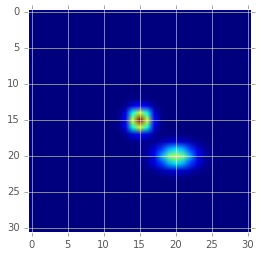

In [3]:
import scipy.stats

## see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

def gaussian2d(grid, m=None, s=None):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    var = scipy.stats.multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

#x, y = np.mgrid[-15:16:1, -15:16:1]
#grid = np.dstack((x, y))
g1 = gaussian2d(grid) + gaussian2d(grid, [5,5], [3,1])
plt.imshow(g1)

## Update: it looks like the actual code uses chebyshev1 polynomials!

Note these are essentially the same but with different scale factors.

In [4]:
# This code works, but I think the next cell is faster.
from numpy.polynomial.chebyshev import chebgrid2d

h0 = chebgrid2d(x, y, c=[[1, 0, 0], [1, 0, 0]])
h1 = chebgrid2d(x, y, c=[[0, 1, 0], [0, 1, 0]])
h2 = chebgrid2d(x, y, c=[[1, 0, 0], [0, 1, 0]])
h3 = chebgrid2d(x, y, c=[[0, 1, 0], [0, 0, 1]])

In [5]:
from numpy.polynomial.chebyshev import chebval2d
h0 = chebval2d(x0, y0, c=[[1, 0, 0], [1, 0, 0]])
h1 = chebval2d(x0, y0, c=[[0, 1, 0], [0, 1, 0]])
h2 = chebval2d(x0, y0, c=[[1, 0, 0], [0, 1, 0]])
h3 = chebval2d(x0, y0, c=[[0, 1, 0], [0, 0, 1]])

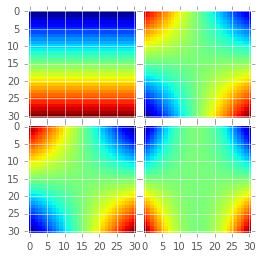

In [6]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (4., 4.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
igrid[0].imshow(h0, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[1].imshow(h1, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[2].imshow(h2, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[3].imshow(h3, interpolation='none')  # The AxesGrid object work as a list of axes.

In [7]:
## The following code does exactly the same as the above:
from numpy.polynomial.chebyshev import chebval
def chebval2d_try(x, y, xord, yord):
    cx = chebval(x, xord)
    cy = chebval(y, yord)
    h0 = np.outer(cx, cy)
    return h0

if False:
    #h0 = chebval2d_try(x, y, [1, 0, 0], [0, 1, 0])
    h0 = chebval2d_try(x, y, [0, 1, 0], [0, 1, 0])
    #h0 = chebval2d_try(x, y, [0, 1, 0], [0, 0, 1])
    print h0.shape
    plt.imshow(h0)

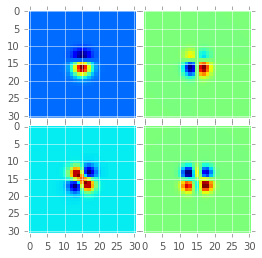

In [8]:
gh0 = gaussian2d(grid, s=[3., 3.]) * h0
gh1 = gaussian2d(grid, s=[3., 3.]) * h1
gh2 = gaussian2d(grid, s=[3., 3.]) * h2
gh3 = gaussian2d(grid, s=[3., 3.]) * h3
fig = plt.figure(1, (4., 4.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
extent = (x0.min(), x0.max(), y0.min(), y0.max())
igrid[0].imshow(gh0, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[1].imshow(gh1, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[2].imshow(gh2, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[3].imshow(gh3, interpolation='none')  # The AxesGrid object work as a list of axes.

## Generate AL basis funcs now...

use same parameters as from the stack.

TBD: is a degGauss of 2 mean it goes up to order 2 (i.e. $x^2$)? Or is it 2 orders so it only goes up to linear ($x$)? Probably the former, so that's what we'll use.

In [9]:
# Parameters from stack
sigGauss = [0.75, 1.5, 3.0]
degGauss = [4, 2, 2]
betaGauss = 1   # in the Becker et al. paper sigGauss is 1 but PSF is more like 2 pixels?
# Parameters from and Becker et al. (2012)
#sigGauss = [0.75, 1.5, 3.0]
#degGauss = [6, 4, 2]

def chebGauss2d(x, y, grid, m=None, s=None, ord=[0,0], beta=1., verbose=False):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    coefLen = np.max(ord)+1
    coef0 = np.zeros(coefLen)
    coef0[ord[0]] = 1
    coef1 = np.zeros(coefLen)
    coef1[ord[1]] = 1
    if verbose:
        print s, ord, coef0, coef1
    ga = gaussian2d(grid, m, np.array(s)/beta)
    ch = chebval2d(x, y, c=np.outer(coef0, coef1))
    return ch * ga

In [10]:
basis = [chebGauss2d(x0, y0, grid, m=[0,0], s=[sig0,sig1], ord=[deg0,deg1], beta=betaGauss, verbose=True) for i0,sig0 in enumerate(sigGauss) for i1,sig1 in enumerate(sigGauss) for deg0 in range(degGauss[i0]+1) for deg1 in range(degGauss[i1]+1)]
print len(basis), basis[0].shape, x0.shape, grid.shape, basis[0].reshape(x0.shape).shape

[0.75, 0.75] [0, 0] [ 1.] [ 1.]
[0.75, 0.75] [0, 1] [ 1.  0.] [ 0.  1.]
[0.75, 0.75] [0, 2] [ 1.  0.  0.] [ 0.  0.  1.]
[0.75, 0.75] [0, 3] [ 1.  0.  0.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [0, 4] [ 1.  0.  0.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [1, 0] [ 0.  1.] [ 1.  0.]
[0.75, 0.75] [1, 1] [ 0.  1.] [ 0.  1.]
[0.75, 0.75] [1, 2] [ 0.  1.  0.] [ 0.  0.  1.]
[0.75, 0.75] [1, 3] [ 0.  1.  0.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [1, 4] [ 0.  1.  0.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [2, 0] [ 0.  0.  1.] [ 1.  0.  0.]
[0.75, 0.75] [2, 1] [ 0.  0.  1.] [ 0.  1.  0.]
[0.75, 0.75] [2, 2] [ 0.  0.  1.] [ 0.  0.  1.]
[0.75, 0.75] [2, 3] [ 0.  0.  1.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [2, 4] [ 0.  0.  1.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [3, 0] [ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[0.75, 0.75] [3, 1] [ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[0.75, 0.75] [3, 2] [ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[0.75, 0.75] [3, 3] [ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[0.75, 0.75] [3, 4] [ 0.

In [11]:
print len(basis), basis[0].shape, basis[0].reshape(x0.shape).shape, 31*31
basis2 = np.dstack(basis).T  # put the bases into an array
print basis2.shape, basis2[0].shape, basis2[0].reshape(x0.shape).shape
print basis[0].min(), basis[0].max(), basis2.min(), basis2.max()

121 (31, 31) (31, 31) 961
(121, 31, 31) (31, 31) (31, 31)
1.0924820179e-131 0.212206590789 -14.1624248714 14.1624248714


Make the two "images". `im1` is the template, `im2` is the science image.

NOTE: having sources near the edges really messes up the fitting (probably because of the convolution). So make sure no sources are near the edge.

37 -15.4089284377 18.7363163731
DescribeResult(nobs=261121, minmax=(-1185.3482329559827, 366.84200330010276), mean=0.0038069308432824018, variance=315.05047973638915, skewness=-27.132960083995673, kurtosis=1253.581701043235)


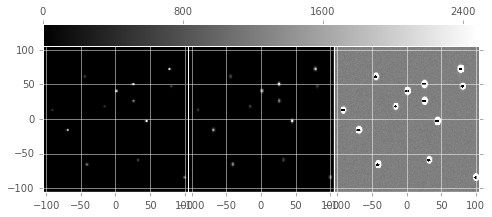

In [12]:
np.random.seed(66)

xim = np.arange(-255, 256, 1)
yim = xim.copy()
y0im, x0im = np.meshgrid(xim, yim)
imgrid = np.dstack((y0im, x0im))
n_sources = 50
fluxes = np.random.uniform(5000, 30000, n_sources)
xposns = np.random.uniform(xim.min()+5, xim.max()-5, n_sources)
yposns = np.random.uniform(yim.min()+5, yim.max()-5, n_sources)

# Make the source closest to the center of the image the one that increases in flux
ind = np.argmin(xposns**2. + yposns**2.)
print ind, xposns[ind], yposns[ind]

sig1 = 0.2  # sigma of template
sig2 = 0.2  # sigma of science image
im1 = np.random.normal(scale=sig1, size=x0im.shape)
im2 = np.random.normal(scale=sig2, size=x0im.shape)

psf1 = 1.6 # sigma in pixels im1 will be template
psf2 = 2.2 # sigma in pixels im2 will be science image. make the psf in this image slighly offset and elongated
for i in range(n_sources):
    im1 += fluxes[i] * gaussian2d(imgrid, m=[xposns[i],yposns[i]], s=[psf1, psf1])
    im2 += fluxes[i] * gaussian2d(imgrid, m=[xposns[i]+0.2,yposns[i]+0.2], s=[psf2, psf2*1.5])
    if i == ind:
        im2 += (fluxes[i]/5.) * gaussian2d(imgrid, m=[xposns[i]+0.2,yposns[i]+0.2], s=[psf2, psf2*1.5])

fig = plt.figure(1, (9, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow((im2-im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10))
igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - im1, axis=None)

Convolve im1 (template) with the basis functions, and make these the *new* bases.

In [13]:
import scipy.signal

basis2 = [scipy.signal.fftconvolve(im1, b, mode='same') for b in basis]
print len(basis2), basis2[0].shape

basis2a = np.vstack([b.flatten() for b in basis2]).T
print basis2a.shape, im2.flatten().shape

121 (511, 511)
(261121, 121) (261121,)


Do the linear fit to compute the matching kernel. The resulting fit is the convolved diffim.

[ -5.67951950e+02  -6.94199451e+02  -1.60947335e+03  -3.05024022e-02
  -7.87571091e-01  -1.33133037e+03  -1.25108921e+00  -1.33040673e+02
   1.44753663e-03  -3.07151986e+00  -1.63291079e+03  -6.90076877e+01
  -3.18844245e+02  -4.33124077e-02  -3.67810002e+00   1.61131420e-02
  -1.02952121e-01   3.07729840e-02   6.31152609e-04  -8.72004344e-04
   1.28045096e+00  -1.52740293e+00  -3.43121314e+00   8.75962159e-04
   5.56208114e-03   9.61477285e+01   9.49621897e+02   2.09607589e+03
  -4.80137940e+00   1.32785022e+00  -8.67472121e-01  -2.18547369e+01
  -4.84816855e+01  -1.10588377e+02   9.00243828e-03  -4.57612936e-02
   3.98299829e-03  -5.91237277e-01   7.15680921e-01   1.45238865e+00
   2.59883820e+02  -1.55309589e+02  -2.74179894e+02   1.35190759e+00
   2.51083523e-01   1.82747374e-01  -3.32372806e+00   2.98465619e+00
   5.23806466e+00   3.67185838e-04  -1.73166863e-03  -2.24730184e-04
   5.69481167e-03  -7.28227542e-03  -1.20836060e-02   8.72401454e+02
   3.82432786e+00  -1.28127710e+02

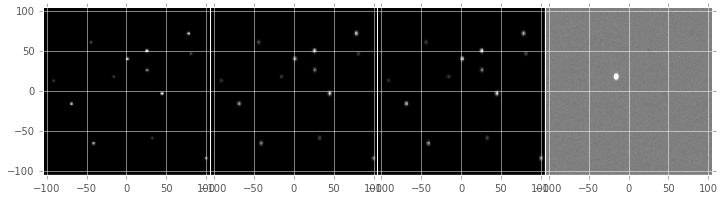

In [14]:
pars, resid, _, _ = np.linalg.lstsq(basis2a, im2.flatten())
print pars
fit = (pars * basis2a).sum(1).reshape(im2.shape)
print resid, np.sum((im2 - fit.reshape(im2.shape))**2), np.sum((im2 - im1)**2)
print basis2a.shape, fit.shape

fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(fit[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[3].imshow((im2 - fit)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10))
#igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - fit, axis=None)

Look at the resulting matching kernel by multiplying the fitted parameters times the original basis funcs. and test that actually convolving it with the template gives us a good subtraction.

(121,) (961, 121)
1.00055116756


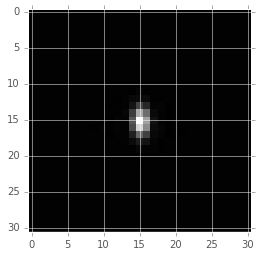

In [15]:
kbasis = np.vstack([b.flatten() for b in basis]).T
print pars.shape, kbasis.shape
kfit = (pars * kbasis).sum(1).reshape(basis[0].shape)
print kfit.sum()
#kfit /= kfit.sum()
plt.imshow(kfit, interpolation='none', cmap='gray')  # this plots the matching kernel

Compare the convolved template to the science image. Also plot the new diffim for comparison.

DescribeResult(nobs=261121, minmax=(-1.1122312267758616, 67.421629294629952), mean=0.0023186776148341765, variance=0.19394149493318746, skewness=80.04091239563894, kurtosis=9281.782838661924)


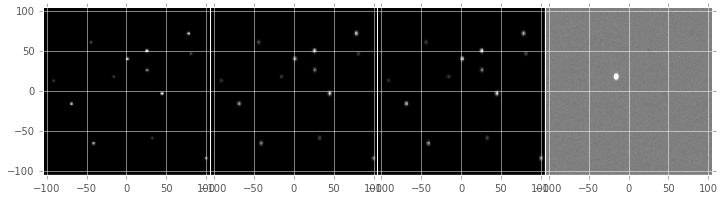

In [16]:
conv_im1 = scipy.ndimage.filters.convolve(im1, kfit, mode='constant')
fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # original template (red)
igrid[1].imshow(conv_im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # convolved template (blue)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # science image (dotted, purple)
igrid[3].imshow((im2 - conv_im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10)) # diffim (grey)
print scipy.stats.describe(im2 - conv_im1, axis=None)

Create the $b_i$ and $M_{ij}$ from the A&L (1998) and Becker (2012) papers. This was done wrong in the previous version of notebook 3 (and above), although it gives identical results.

(121,)
(121, 121)
[ -1.60816176e+01   5.73163140e-02  -8.08538785e-01  -2.87098613e-02
  -5.62091648e-02   6.83752808e-02  -1.56325560e+00   3.92234176e-01
   4.39267030e-02   8.14666256e-04  -5.62334016e-01  -3.76714861e-01
  -1.36512019e-01  -3.84128276e-02   4.07425879e-03   1.30627400e-02
  -1.69793093e-01   3.49804977e-02   6.41047512e-04  -6.05722969e-04
  -4.61104148e-02  -1.85073771e-03  -2.47706885e-02   4.13538406e-04
   7.30972576e-04   4.29414118e+00  -1.30992216e-03  -6.15957872e-01
   4.31148300e-02   2.15585270e+00  -4.56318243e-01   2.71564864e+00
   7.74353391e-02   6.43901615e-01   7.91483200e-03  -7.65177096e-02
   7.29682724e-03  -3.70314866e-03  -5.52647016e-04  -2.42520427e-03
   3.47868049e+00  -7.18814143e-03  -2.77552025e-01  -1.43293771e-01
   4.19734353e-01   1.28344851e-02  -6.41699223e-01  -4.78376205e-03
  -9.13860083e-02   3.26615544e-04  -2.87002623e-03  -1.00754132e-04
   5.39403760e-04   3.27595427e-05   3.59810075e-04   3.84288286e+00
  -7.70318802e-0

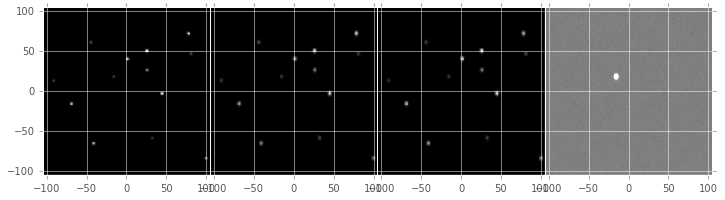

In [17]:
b = (basis2a.T * im2.flatten()).sum(1)
print b.shape

M = np.dot(basis2a.T, basis2a)
print M.shape

pars2, resid, _, _ = np.linalg.lstsq(M, b)
print pars2
#print 'Difference (log10):\n', np.log10(np.abs((pars2-pars)/pars2))

fit2 = (pars2 * basis2a).sum(1).reshape(im1.shape)
print basis2a.shape, fit2.shape

fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(fit2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[3].imshow((im2 - fit2)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10))
#igrid.cbar_axes[0].colorbar(gim)
print scipy.stats.describe(im2 - fit2, axis=None)
#print pars2-pars

(121,) (961, 121)
1.00055739931


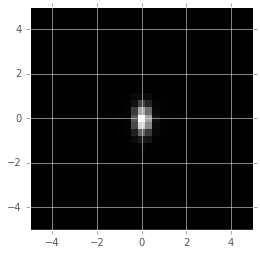

In [18]:
kbasis = np.vstack([b.flatten() for b in basis]).T
print pars2.shape, kbasis.shape
kfit2 = (pars2 * kbasis).sum(1).reshape(basis[0].shape)
print kfit2.sum()
#kfit2 /= kfit2.sum()
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
plt.imshow(kfit2, extent=extent, interpolation='none', cmap='gray')  # this plots the matching kernel

(511, 511) -0.239855372124 1678.67703398
DescribeResult(nobs=261121, minmax=(1.0577885597507546e-14, 1405050.4333718705), mean=315.04928769850039, variance=124622240.06103805, skewness=68.31222851977353, kurtosis=5837.2801940304835)
DescribeResult(nobs=261121, minmax=(1.9542194579257855e-12, 4545.3429417077587), mean=0.19395258954955916, variance=349.25446666832573, skewness=165.38262101913475, kurtosis=30817.62706060099)
DescribeResult(nobs=261121, minmax=(-1.1142789685420667, 67.419158565705629), mean=0.0023018080894409822, variance=0.19394803398065333, skewness=80.03699015941088, kurtosis=9281.133327866757)


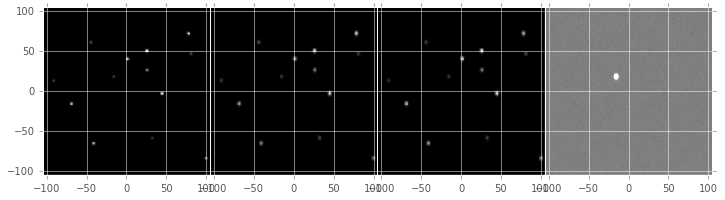

In [19]:
conv_im1 = scipy.ndimage.filters.convolve(im1, kfit2, mode='constant')
print conv_im1.shape, conv_im1.min(), conv_im1.max()
print scipy.stats.describe((im2 - im1)**2, axis=None)
print scipy.stats.describe((im2 - conv_im1)**2, axis=None)

fig = plt.figure(1, (12, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # original template (red)
igrid[1].imshow(conv_im1[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # convolved template (blue)
igrid[2].imshow(im2[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent) # science image (dotted, purple)
igrid[3].imshow((im2 - conv_im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10)) # diffim (grey)
print scipy.stats.describe(im2 - conv_im1, axis=None)

Add taking into account PSF variations... (next notebook, #4)

## Compute the "L(ZOGY)" post-conv. kernel from kfit

1.37842010852
-0.0368869211232
0.999724454203


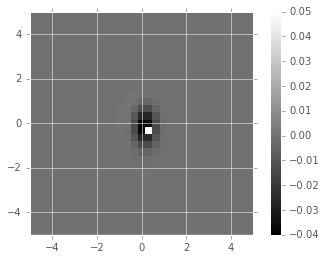

In [20]:
from scipy.fftpack import fft2, ifft2, fftfreq, fftshift

def kernel_ft2(kernel):
    FFT = fft2(kernel)
    return FFT
def post_conv_kernel_ft2(kernel, sig1=1., sig2=1.):
    kft = kernel_ft2(kernel)
    return np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2))
def post_conv_kernel2(kernel, sig1=1., sig2=1.):
    kft = post_conv_kernel_ft2(kernel, sig1, sig2)
    out = ifft2(kft)
    return out

pck = post_conv_kernel2(kfit, sig1=sig2, sig2=sig1)
print pck.real.max()
print pck.real.min()
print pck.real.sum()
pck = np.fft.ifftshift(pck.real)
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
plt.imshow(pck, extent=extent, interpolation='none', cmap='gray', clim=(-0.04,0.05))  # this plots the matching kernel
plt.colorbar()

## Now convolve the image difference with the kernel.

0.999724454203 1.37842010852 -0.0368869211232
DescribeResult(nobs=261121, minmax=(-1.4407213682329558, 78.426777379833638), mean=0.00231911509528807, variance=0.26181768924329057, skewness=71.55471405113268, kurtosis=8292.468619887146)
DescribeResult(nobs=261121, minmax=(-1.1142789685420667, 67.419158565705629), mean=0.0023018080894409822, variance=0.19394803398065333, skewness=80.03699015941088, kurtosis=9281.133327866757)


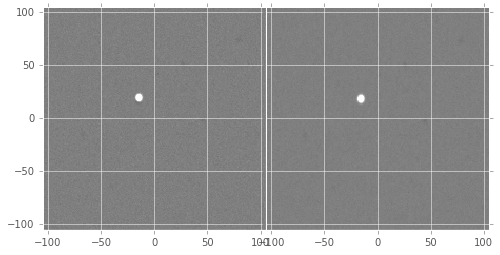

In [21]:
print pck.sum(), pck.max(), pck.min()
#pck /= pck.sum()
pci = scipy.ndimage.filters.convolve(im2-conv_im1, pck, mode='constant')

fig = plt.figure(1, (8, 4))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0)
extent = (x0im.min()+150, x0im.max()-150, y0im.min()+150, y0im.max()-150)
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
gim = igrid[0].imshow(pci[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10)) # corrected diffim
igrid[1].imshow((im2 - conv_im1)[x1d:x2d,y1d:y2d], origin='lower', interpolation='none', cmap='gray', extent=extent, clim=(-10,10)) # original diffim
print scipy.stats.describe(pci, axis=None)
print scipy.stats.describe(im2 - conv_im1, axis=None)

Corrected: 0.00231911509529 0.511680258145
Original:  0.00230180808944 0.440394472296
Expected:  0.282842712475


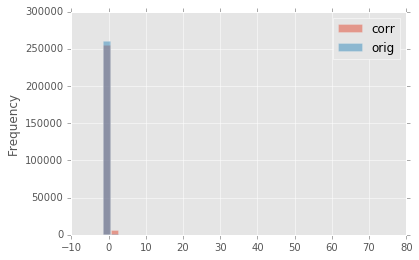

In [22]:
import pandas as pd
df = pd.DataFrame({'corr': pci.flatten(), 'orig': (im2-conv_im1).flatten()})
df.plot.hist(alpha=0.5, bins=40)
print 'Corrected:', np.mean(pci), np.std(pci)
print 'Original: ', np.mean(im2-conv_im1), np.std(im2-conv_im1)
print 'Expected: ', np.sqrt(sig1**2 + sig2**2)

## Compute the (corrected) diffim's new PSF

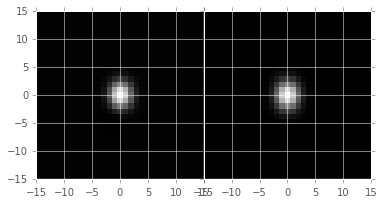

In [23]:
# post_conv_psf = phi_1(k) * sym.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kappa_ft(k)**2))
# we'll parameterize phi_1(k) as a gaussian with sigma "psfsig1".

def kernel_ft2(kernel):
    FFT = fft2(kernel)
    return FFT
def post_conv_psf_ft2(psf, kernel, sig1=1., sig2=1.):
    psf_ft = kernel_ft2(psf)
    kft = kernel_ft2(kernel)
    out = psf_ft * np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2))
    return out
def post_conv_psf(psf, kernel, sig1=1., sig2=1.):
    kft = post_conv_psf_ft2(psf, kernel, sig1, sig2)
    out = ifft2(kft)
    return out

# First compute the science image's (im2's) psf -- easy since we parameterized it above when we made the image
im2_psf = gaussian2d(grid, m=[0, 0], s=[psf2, psf2*1.5])

pcf = post_conv_psf(psf=im2_psf, kernel=kfit, sig1=sig2, sig2=sig1)
pcf = pcf.real / pcf.real.sum()

fig = plt.figure(1, (6, 3))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.0)
extent = (x0.min(), x0.max(), y0.min(), y0.max())
gim = igrid[0].imshow(pcf, origin='lower', interpolation='none', cmap='gray', extent=extent) # corrected psf
igrid[1].imshow(im2_psf, origin='lower', interpolation='none', cmap='gray', extent=extent) # original psf

Look at how detection would compare in the new diffim vs. the original one by convolving them with their psfs.

In [24]:
tmp1 = scipy.ndimage.filters.convolve(pci, pcf, mode='constant')
#plt.plot(xim, tmp1)  # red - corrected
tmp2 = scipy.ndimage.filters.convolve(im2-conv_im1, im2_psf, mode='constant')
#plt.plot(xim, tmp2)  # blue - original

Detect 5-$\sigma$ sources. First compute stats on the convolved diffim's.

1.54846225548 1.39087751761
90 110
0.270355500489 0.227697675636
1: 381
-232 239
2: 437
-233 238


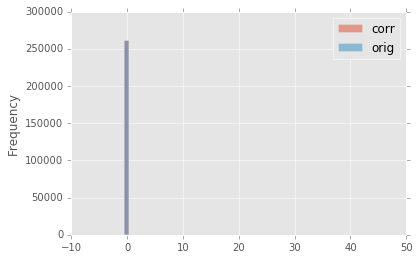

In [25]:
df = pd.DataFrame({'corr': tmp1.flatten(), 'orig': tmp2.flatten()})
df.plot.hist(alpha=0.5, bins=50)

print tmp1.std()*5., tmp2.std()*5.
print np.sum(np.abs(tmp1) > tmp1.std()*5.), np.sum(np.abs(tmp2) > tmp2.std()*5.)

import scipy.stats
tmp1a, low, upp = scipy.stats.sigmaclip(tmp1)
tmp2a, low, upp = scipy.stats.sigmaclip(tmp2)
print tmp1a.std()*5., tmp2a.std()*5.

det1 = x0im[np.abs(tmp1) > tmp1a.std()*5.]
det2 = x0im[np.abs(tmp2) > tmp2a.std()*5.]
print '1:', len(det1)
if len(det1) > 0: 
    print det1.min(), det1.max()
print '2:', len(det2)
if len(det2) > 0:
    print det2.min(), det2.max()

#xaxs = np.linspace(df.min()[0], df.max()[0])
#plt.plot(xaxs, 200*gaussian(xaxs, s=tmp1a.std()), color='r')
#plt.plot(xaxs, 200*gaussian(xaxs, s=tmp2a.std()), color='b')
#plt.plot(np.repeat(tmp1a.std()*5., 2), [-0, 800], color='r')
#plt.plot(np.repeat(-tmp1a.std()*5., 2), [-0, 800], color='r')
#plt.plot(np.repeat(tmp2a.std()*5., 2), [-0, 800], color='b')
#plt.plot(np.repeat(-tmp2a.std()*5., 2), [-0, 800], color='b')